# Scaling up GNNs with GraphSAGE

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(-1)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Pubmed

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [3]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[419, 500], edge_index=[2, 464], y=[419], train_mask=[419], val_mask=[419], test_mask=[419], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[268, 500], edge_index=[2, 311], y=[268], train_mask=[268], val_mask=[268], test_mask=[268], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[289, 500], edge_index=[2, 324], y=[289], train_mask=[289], val_mask=[289], test_mask=[289], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[189, 500], edge_index=[2, 225], y=[189], train_mask=[189], val_mask=[189], test_mask=[189], input_id=[12], batch_size=12)


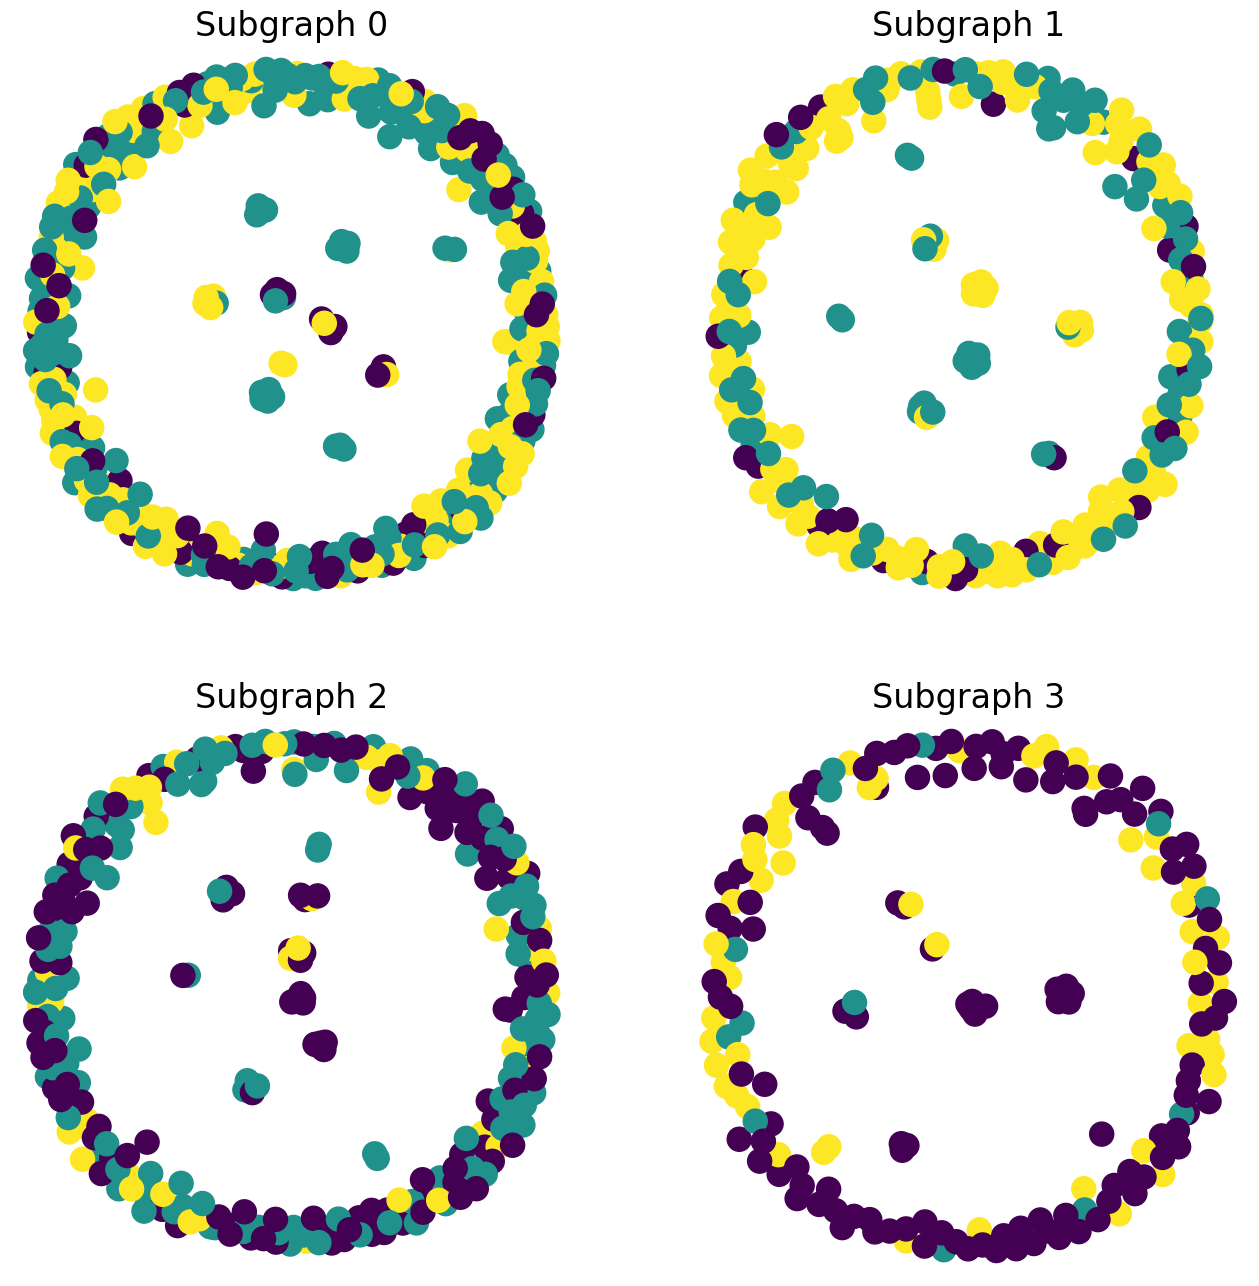

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

In [5]:
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(loader):.3f} | Train Acc: {acc/len(loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [6]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(train_loader, 200)

# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.314 | Train Acc:  28.77% | Val Loss: 1.12 | Val Acc: 24.94%
Epoch  20 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.67 | Val Acc: 66.43%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 84.72%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 75.13%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.45 | Val Acc: 83.33%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.47 | Val Acc: 83.02%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.50 | Val Acc: 80.35%


Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.44 | Val Acc: 77.43%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 78.22%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.33 | Val Acc: 84.15%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 71.43%
GraphSAGE test accuracy: 75.70%


## PPI

In [7]:
import torch
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load training, evaluation, and test sets
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".", split='val')
test_dataset = PPI(root=".", split='test')

# Unify the training graphs and apply neighbor sampling
train_data = Batch.from_data_list(train_dataset)
train_loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20, 10], num_workers=2, persistent_workers=True)

# Evaluation loaders (one datapoint corresponds to a graph)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes,
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def fit(loader):
    model.train()

    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(loader.data)

@torch.no_grad()
def test(loader):
    model.eval()

    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = (out > 0).float().cpu()

    y, pred = data.y.numpy(), preds.numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

for epoch in range(301):
    loss = fit(train_loader)
    val_f1 = test(val_loader)
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1-score: {val_f1:.4f}')

print(f'Test F1-score: {test(test_loader):.4f}')

Epoch   0 | Train Loss: 12.689 | Val F1-score: 0.4917
Epoch  50 | Train Loss: 8.740 | Val F1-score: 0.7966
Epoch 100 | Train Loss: 8.609 | Val F1-score: 0.8088
Epoch 150 | Train Loss: 8.534 | Val F1-score: 0.8197
Epoch 200 | Train Loss: 8.486 | Val F1-score: 0.8250
Epoch 250 | Train Loss: 8.459 | Val F1-score: 0.8258
Epoch 300 | Train Loss: 8.456 | Val F1-score: 0.8263
Test F1-score: 0.8504


# summary

1. Example: Node Classification on PubMed Using GraphSAGE

Processing...


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Done!


Subgraph 0: Data(x=[280, 500], edge_index=[2, 328], y=[280], train_mask=[280], val_mask=[280], test_mask=[280], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[266, 500], edge_index=[2, 336], y=[266], train_mask=[266], val_mask=[266], test_mask=[266], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[282, 500], edge_index=[2, 312], y=[282], train_mask=[282], val_mask=[282], test_mask=[282], input_id=[16], batch_size=16)


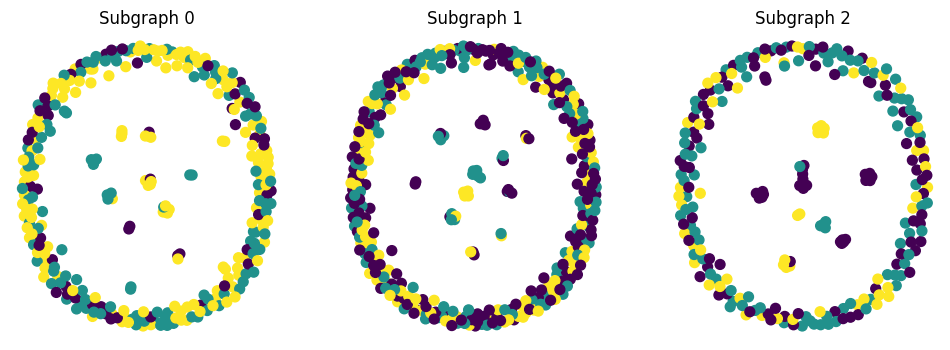

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 1.0980 | Train Acc: 36.60%
Epoch  20 | Train Loss: 0.0185 | Train Acc: 100.00%
Epoch  40 | Train Loss: 0.0027 | Train Acc: 100.00%
Epoch  60 | Train Loss: 0.0013 | Train Acc: 100.00%
Epoch  80 | Train Loss: 0.0012 | Train Acc: 100.00%
Epoch 100 | Train Loss: 0.0016 | Train Acc: 100.00%
Epoch 120 | Train Loss: 0.0016 | Train Acc: 100.00%
Epoch 140 | Train Loss: 0.0004 | Train Acc: 100.00%
Epoch 160 | Train Loss: 0.0001 | Train Acc: 100.00%
Epoch 180 | Train Loss: 0.0002 | Train Acc: 100.00%
Epoch 200 | Train Loss: 0.0002 | Train Acc: 100.00%

GraphSAGE test accuracy: 76.70%


In [9]:
# pubmed_graphsage.py
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import torch_geometric.transforms as T

# -----------------------------
# Set seeds and device
# -----------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# Load the PubMed dataset
# -----------------------------
dataset = Planetoid(root='./data/PubMed', name="Pubmed", transform=T.NormalizeFeatures())
data = dataset[0]

print(f"Dataset: {dataset}")
print('-------------------')
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

print("\nGraph:")
print("------")
print(f"Training nodes: {int(data.train_mask.sum())}")
print(f"Evaluation nodes: {int(data.val_mask.sum())}")
print(f"Test nodes: {int(data.test_mask.sum())}")
print(f"Edges are directed: {data.is_directed()}")
print(f"Graph has isolated nodes: {data.has_isolated_nodes()}")
print(f"Graph has loops: {data.has_self_loops()}")

# -----------------------------
# Create the NeighborLoader for mini-batching
# -----------------------------
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],       # sample 5 neighbors at the 1st hop and 10 at the 2nd
    batch_size=16,
    input_nodes=data.train_mask,
    shuffle=True,
    num_workers=4,               # increase the number of worker processes to load data faster
    persistent_workers=True,     # persistent workers for speedup between epochs
)

# (Optional) Visualize a few sampled subgraphs:
for i, subdata in enumerate(train_loader):
    print(f"Subgraph {i}: {subdata}")
    if i >= 2:
        # Only show a few examples.
        break

fig = plt.figure(figsize=(12, 4))
for idx, (subdata, pos_num) in enumerate(zip(train_loader, [131, 132, 133])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos_num)
    ax.set_title(f"Subgraph {idx}")
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), with_labels=False,
                     node_color=subdata.y.cpu(), node_size=50)
    plt.axis('off')
plt.show()

# -----------------------------
# Define the GraphSAGE model
# -----------------------------
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.sage2(x, edge_index)
        return x

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.train()

        for epoch in range(epochs + 1):
            total_loss = 0.0
            total_acc = 0.0
            batch_count = 0

            for batch in loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                # Calculate accuracy on the training nodes in the batch
                pred = out[batch.train_mask].argmax(dim=1)
                acc = (pred == batch.y[batch.train_mask]).sum().item() / int(batch.train_mask.sum())
                total_acc += acc
                batch_count += 1

            if epoch % 20 == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {total_loss / batch_count:.4f} | Train Acc: {total_acc / batch_count * 100:.2f}%")

    @torch.no_grad()
    def test(self, data):
        self.eval()
        data = data.to(device)
        out = self(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
        acc = correct / int(data.test_mask.sum())
        return acc

# -----------------------------
# Initialize the model and wrap with DataParallel if multiple GPUs are available
# -----------------------------
model = GraphSAGE(dataset.num_features, 64, dataset.num_classes).to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)

print(model)

# -----------------------------
# Train and test
# -----------------------------
model.fit(train_loader, epochs=200)
# When using DataParallel, the original methods are available as model.module
test_acc = model.module.test(data) if isinstance(model, torch.nn.DataParallel) else model.test(data)
print(f"\nGraphSAGE test accuracy: {test_acc * 100:.2f}%")

2. Example: Multi‑Label Classification on PPI Using GraphSAGE (Inductive Setting)

In [10]:
# ppi_graphsage.py
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.data import Batch
from torch_geometric.nn import GraphSAGE as PyGGraphSAGE  # using PyG’s built-in GraphSAGE
from sklearn.metrics import f1_score

# -----------------------------
# Set seeds and device
# -----------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# Load the PPI datasets (train, validation, test)
# -----------------------------
train_dataset = PPI(root='./data/PPI', split='train')
val_dataset = PPI(root='./data/PPI', split='val')
test_dataset = PPI(root='./data/PPI', split='test')

# -----------------------------
# Unify training graphs for neighbor sampling
# -----------------------------
train_data = Batch.from_data_list(train_dataset)
train_loader = NeighborLoader(
    train_data,
    batch_size=2048,
    shuffle=True,
    num_neighbors=[20, 10],
    num_workers=4,
    persistent_workers=True,
)

# For evaluation, we use DataLoader (each sample is a whole graph)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4)

# -----------------------------
# Initialize PyG’s built-in GraphSAGE model
# -----------------------------
model = PyGGraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes,
).to(device)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# -----------------------------
# Training function
# -----------------------------
def fit(loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# -----------------------------
# Testing function (using F1 score)
# -----------------------------
@torch.no_grad()
def evaluate(loader):
    model.eval()
    # For evaluation, we assume the loader returns whole graphs (batch_size=2)
    data = next(iter(loader)).to(device)
    out = model(data.x, data.edge_index)
    preds = (out > 0).float().cpu().numpy()
    y_true = data.y.cpu().numpy()
    # Calculate micro F1 score; if there are no positive predictions, return 0
    return f1_score(y_true, preds, average='micro') if preds.sum() > 0 else 0

# -----------------------------
# Train for 300 epochs, checking validation performance
# -----------------------------
for epoch in range(301):
    loss = fit(train_loader)
    if epoch % 50 == 0:
        val_f1 = evaluate(val_loader)
        print(f"Epoch {epoch:3d} | Train Loss: {loss:.4f} | Val F1-score: {val_f1:.4f}")

test_f1 = evaluate(test_loader)
print(f"\nPPI Test F1-score: {test_f1:.4f}")

Extracting data/PPI/ppi.zip
Processing...
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
Done!
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch   0 | Train Loss: 0.0057 | Val F1-score: 0.4867


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch  50 | Train Loss: 0.0039 | Val F1-score: 0.7934


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 100 | Train Loss: 0.0038 | Val F1-score: 0.8109


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 150 | Train Loss: 0.0038 | Val F1-score: 0.8188


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 200 | Train Loss: 0.0038 | Val F1-score: 0.8184


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 250 | Train Loss: 0.0038 | Val F1-score: 0.8246


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 300 | Train Loss: 0.0038 | Val F1-score: 0.8277


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)



PPI Test F1-score: 0.8522


testing gpu resource 2nd

In [11]:
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE
from sklearn.metrics import f1_score

# -----------------------------
# Basic Settings and Optimizations
# -----------------------------
cudnn.benchmark = True  # enables cuDNN auto-tuner for faster runtime

# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device (ensure that you have a GPU with ~24GB VRAM available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# Load the PPI datasets
# -----------------------------
train_dataset = PPI(root="./data/PPI", split="train")
val_dataset = PPI(root="./data/PPI", split="val")
test_dataset = PPI(root="./data/PPI", split="test")

# Unify training graphs into one big graph for neighbor sampling
train_data = Batch.from_data_list(train_dataset)

# -----------------------------
# DataLoader Settings to Maximize VRAM Usage
# -----------------------------
# Set an aggressive batch size. Here we use 8192 for neighbor sampling.
# (Adjust TRAIN_BATCH_SIZE as needed to approach 24GB usage on your GPU.)
TRAIN_BATCH_SIZE = 8192

train_loader = NeighborLoader(
    train_data,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_neighbors=[20, 10],        # Two-layer sampling: 20 neighbors at 1st hop, 10 at 2nd
    num_workers=8,                 # Increase workers for faster data loading
    persistent_workers=True,       # Reuse worker processes across epochs
    pin_memory=True                # Use pinned memory for faster host-to-device copies
)

# For evaluation, each data point is a whole graph.
EVAL_BATCH_SIZE = 2
val_loader = DataLoader(
    val_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

# -----------------------------
# Initialize the GraphSAGE Model
# -----------------------------
model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes
).to(device)

# Use DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = torch.nn.DataParallel(model)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Optionally, use automatic mixed precision to speed up computation
scaler = torch.cuda.amp.GradScaler()

# -----------------------------
# Training Function
# -----------------------------
def fit(loader):
    model.train()
    total_loss = 0.0
    total_graphs = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * data.num_graphs
        total_graphs += data.num_graphs

    return total_loss / total_graphs

# -----------------------------
# Evaluation Function
# -----------------------------
@torch.no_grad()
def evaluate(loader):
    model.eval()
    # Evaluation: each sample is a whole graph (batch_size=EVAL_BATCH_SIZE)
    data = next(iter(loader)).to(device)
    out = model(data.x, data.edge_index)
    preds = (out > 0).float().cpu().numpy()
    y_true = data.y.cpu().numpy()
    # Compute micro F1 score; if there are no positive predictions, return 0
    score = f1_score(y_true, preds, average='micro') if preds.sum() > 0 else 0
    return score

# -----------------------------
# Training Loop
# -----------------------------
num_epochs = 301
for epoch in range(num_epochs):
    loss = fit(train_loader)
    if epoch % 50 == 0:
        val_f1 = evaluate(val_loader)
        print(f"Epoch {epoch:3d} | Train Loss: {loss:.4f} | Val F1-score: {val_f1:.4f}")

# -----------------------------
# Final Test Evaluation
# -----------------------------
test_f1 = evaluate(test_loader)
print(f"\nTest F1-score: {test_f1:.4f}")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch   0 | Train Loss: 0.6225 | Val F1-score: 0.4585


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch  50 | Train Loss: 0.3655 | Val F1-score: 0.7755


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 100 | Train Loss: 0.3417 | Val F1-score: 0.8084


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 150 | Train Loss: 0.3322 | Val F1-score: 0.8207


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 200 | Train Loss: 0.3279 | Val F1-score: 0.8271


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 250 | Train Loss: 0.3242 | Val F1-score: 0.8318


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


Epoch 300 | Train Loss: 0.3206 | Val F1-score: 0.8363


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)



Test F1-score: 0.8588
